**Классификатор изображений на основе свёрточной сети LeNet**

Евгений Борисов <esborisov@sevsu.ru>

Backpropagation applied to handwritten zip code recognition.    
LeCun Y., Boser B., Denker J.S., Henderson D., Howard R.E., Hubbard W., Jackel L.D.   
Neural Computation 1989 1(4):541-551.    
http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf   

# загружаем данные

In [1]:
# !pip install tqdm
# !pip install torchvision

In [2]:
import torch

In [3]:
import torchvision
# from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as MNIST
# from torch.utils.data import DataLoader
from torchvision import transforms

transform  = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((.5),(.5)) ])
ds_train = MNIST(root='./data', train=True,  download=True, transform=transform)
ds_test  = MNIST(root='./data', train=False, download=True, transform=transform)

target_names = ds_train.classes
n_classes = len(target_names)

display(ds_train.data.shape)
display(n_classes)

torch.Size([60000, 28, 28])

10

In [4]:
from tqdm.auto import tqdm
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

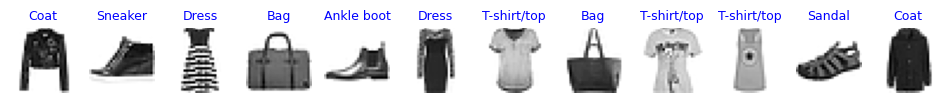

In [5]:
n_show = 12
n_samples = ds_train.data.shape[0]
fig,ax = plt.subplots(1,n_show,figsize=(12,3))
for n,i in enumerate(rng.permutation(n_samples)[:n_show]):
    ax[n].imshow(ds_train.data[i],cmap='gray_r')
    ax[n].set_title(target_names[ ds_train.targets[i]],color='b',fontsize=9)
    ax[n].axis('off')

# модель

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
          ('conv1',  nn.Conv2d(in_channels=1,out_channels=8,kernel_size=5)),
          ('relu1',  nn.ReLU()),
          ('mpool1', nn.MaxPool2d(kernel_size=2) ),
          ('conv2',  nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3)),
          ('relu2',  nn.ReLU()),
          ('flat',   nn.Flatten(start_dim=1) ),
          ('lin1',   nn.Linear(in_features=1600,out_features=n_classes) ),
          ('smax',   nn.Softmax(dim=-1) ),
        ]))

display(model)

Sequential(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=1600, out_features=10, bias=True)
  (smax): Softmax(dim=-1)
)

In [8]:
# from collections import OrderedDict

# model = nn.Sequential(OrderedDict([
#           ('conv1',  nn.Conv2d(in_channels=1,out_channels=24,kernel_size=3)),
#           ('relu1',  nn.ReLU()),
#           ('mpool1', nn.MaxPool2d(kernel_size=2) ),
#           ('conv2',  nn.Conv2d(in_channels=24,out_channels=64,kernel_size=3)),
#           ('relu2',  nn.ReLU()),
#           ('flat',   nn.Flatten(start_dim=1) ),
#           ('lin1',   nn.Linear(in_features=7744,out_features=n_classes) ),
#           ('smax',   nn.Softmax(dim=-1) ),
#         ]))

# model

In [9]:
# from torch.utils.data import DataLoader
# for x,t in DataLoader( ds_train, batch_size=16, shuffle=True): break
# # display(( x.shape, t.shape ))
# # display(( x.min(),x.max() ))
# o = model(x)
# display(o.shape)

In [10]:
# ds_train.classes
# set(ds_train.targets.numpy())

### обучаем модель

In [11]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Quadro K620'

In [12]:
model = model.to(device)

criterion =  nn.BCELoss() # ф-ция потери
# criterion = nn.CrossEntropyLoss()

# метод оптимизации
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) 

----

In [13]:
from torch.utils.data import DataLoader

In [14]:
loss_history = [] # значения ф-ции потери
acc_history = []

In [15]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

In [16]:
%%time

n_epoch = 32 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []

    # получаем батч учебных примеров
    for x,t in DataLoader( ds_train, batch_size=len(ds_train)//4, shuffle=True): 
        o = model.forward(x.to(device)) # считаем выход модели
        t_ = F.one_hot( t, num_classes=n_classes ).to( torch.float32 ) 
        loss = criterion( o, t_.to(device) ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    
    with torch.set_grad_enabled(False):
        for x,t in DataLoader( ds_train, batch_size=len(ds_train)//4, shuffle=False): 
            o = model.forward(x.to(device)).cpu().numpy()
            break
    p = np.argmax(o,axis=-1)
    acc_history.append(accuracy_score(y_true=t.numpy(), y_pred=p))
    if acc_history[-1]>.99: break

  0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 8min 3s, sys: 1.37 s, total: 8min 5s
Wall time: 8min 6s


----

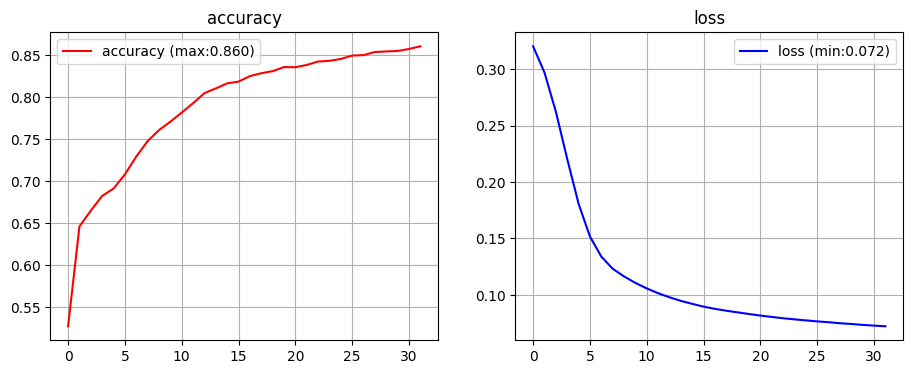

In [17]:
# история изменения значений погрешности модели
fig,ax = plt.subplots(ncols=2,figsize=(11,4))
ax[0].plot(acc_history,label=f'accuracy (max:{max(acc_history):.3f})',c='r' )
ax[0].grid()
ax[0].set_title('accuracy')
ax[0].legend()
ax[1].plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
ax[1].grid()
ax[1].set_title('loss')
ax[1].legend()

In [18]:
# # история изменения значений погрешности модели
# fig,ax = plt.subplots()
# ax.plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
# ax.grid()
# ax.set_title('loss')
# ax.legend()

## тестируем

### учебный датасет

In [19]:
from sklearn.metrics import classification_report

images,label,score = [],[],[]

with torch.no_grad():
    for x,target in tqdm(DataLoader(ds_train, batch_size=len(ds_train)//4, shuffle=False)):
        images.append(x.numpy() ) 
        label.append( target.numpy() )
        score.append( model(x.to(device)).cpu().detach().numpy() )

target = np.hstack(label)
predicted = np.argmax(np.vstack(score),axis=1)
print(  classification_report( target,predicted, target_names=target_names, ) )

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.81      0.82      6000
     Trouser       0.98      0.96      0.97      6000
    Pullover       0.74      0.77      0.76      6000
       Dress       0.85      0.88      0.87      6000
        Coat       0.76      0.77      0.77      6000
      Sandal       0.94      0.94      0.94      6000
       Shirt       0.65      0.59      0.62      6000
     Sneaker       0.92      0.92      0.92      6000
         Bag       0.94      0.95      0.95      6000
  Ankle boot       0.94      0.96      0.95      6000

    accuracy                           0.86     60000
   macro avg       0.85      0.86      0.86     60000
weighted avg       0.85      0.86      0.86     60000



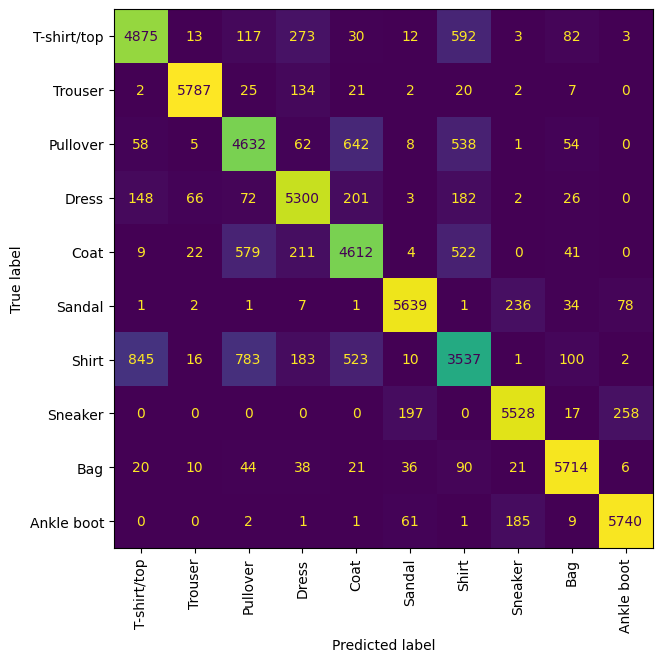

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(target,predicted), 
        display_labels=target_names,
    )
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='viridis',  colorbar=False,)
plt.show()

### тестовый датасет

In [22]:
images,label,score = [],[],[]

with torch.no_grad():
    for x,target in tqdm(DataLoader(ds_test, batch_size=len(ds_test)//2, shuffle=False)):
        images.append(x.numpy() ) 
        label.append( target.numpy() )
        score.append( model(x.to(device)).cpu().detach().numpy() )
np.hstack(label)


target = np.hstack(label)
predicted = np.argmax(np.vstack(score),axis=1)
print(  classification_report( target,predicted, target_names=target_names, ) )

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.80      0.81      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.72      0.76      0.74      1000
       Dress       0.84      0.87      0.85      1000
        Coat       0.76      0.74      0.75      1000
      Sandal       0.94      0.94      0.94      1000
       Shirt       0.60      0.56      0.58      1000
     Sneaker       0.91      0.92      0.92      1000
         Bag       0.93      0.96      0.95      1000
  Ankle boot       0.94      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.84      0.85      0.84     10000



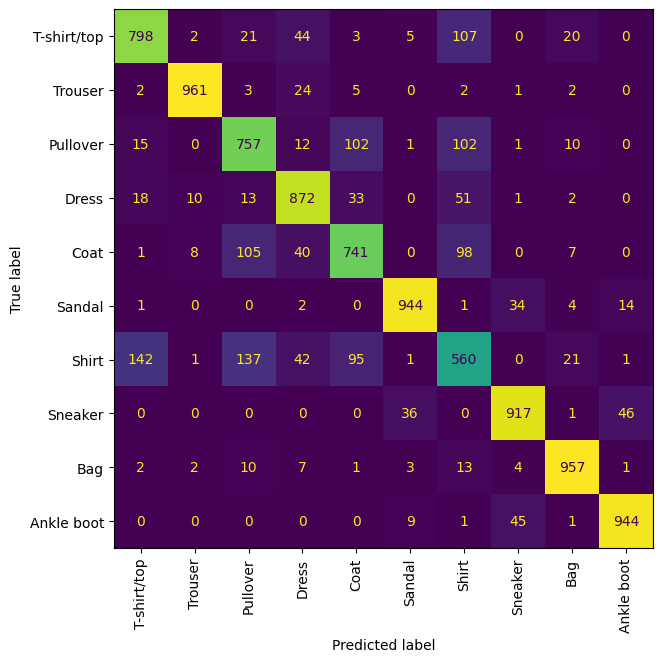

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(target,predicted), 
        display_labels=target_names,
    )
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='viridis',  colorbar=False,)
plt.show()

In [26]:
# !pip3 install watermark
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.14.0

torch      : 2.2.2
numpy      : 1.25.2
matplotlib : 3.7.2
torchvision: 0.17.2

